1. using electricity data first for now
2. imputing mean/median for missing data
3. Making electricity usage for each hours "independent" (? would this be the right terminology? I'm not sure)
    - what I am trying to convey here is that I am training for each individual electricity usage based on building characteristics and weather data.
    - is this the correct way to model time series data? I don't know.
    - After I am done with this method, I can compare the predictions for a day/month

# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

# Load Data

In [2]:
electricity_data = pd.read_csv('data_meter_0.csv')
electricity_data=electricity_data.drop(['Unnamed: 0'],axis=1)
electricity_data=electricity_data.drop(['meter_reading_log'],axis=1)
electricity_data.head()

,site_id,building_id,primary_use,meter,timestamp,meter_reading,square_feet,year_built,floor_count,air_temperature,dew_temperature,cloud_coverage,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,Education,0,2016-01-01 00:00:00,0.0,7432,2008.0,NaN,25.0,20.0,6.0,NaN,1019.7,0.0,0.0
1,0,1,Education,0,2016-01-01 00:00:00,0.0,2720,2004.0,NaN,25.0,20.0,6.0,NaN,1019.7,0.0,0.0
2,0,2,Education,0,2016-01-01 00:00:00,0.0,5376,1991.0,NaN,25.0,20.0,6.0,NaN,1019.7,0.0,0.0
3,0,3,Education,0,2016-01-01 00:00:00,0.0,23685,2002.0,NaN,25.0,20.0,6.0,NaN,1019.7,0.0,0.0
4,0,4,Education,0,2016-01-01 00:00:00,0.0,116607,1975.0,NaN,25.0,20.0,6.0,NaN,1019.7,0.0,0.0


In [3]:
electricity_data['timestamp']=pd.to_datetime(electricity_data['timestamp'],format='%Y-%m-%d %H:%M:%S')
electricity_data['month']=electricity_data['timestamp'].dt.month
electricity_data['day']=electricity_data['timestamp'].dt.day
electricity_data['dayofweek']=electricity_data['timestamp'].dt.dayofweek
electricity_data['hour']=electricity_data['timestamp'].dt.hour
electricity_data['minute']=electricity_data['timestamp'].dt.minute

In [4]:
total_meter_readings_by_building=electricity_data.groupby('building_id').sum()['meter_reading'].reset_index()
total_meter_readings_by_building

,building_id,meter_reading
0,0,1.286461e+06
1,1,6.576176e+05
2,2,1.278194e+05
3,3,2.069071e+06
4,4,8.578074e+06
...,...,...
1408,1444,5.389637e+04
1409,1445,3.387925e+04
1410,1446,2.589332e+04
1411,1447,1.346772e+06


load the building metadata. This is what will be used for the train/test split. Here we have to edit sites 11 and 8 because these are duplicates with sites 7 and 0. 

In [5]:
building_metadata=pd.read_csv('ashrae-energy-prediction/building_metadata.csv')
building_metadata.replace({'site_id': {11: 7, 8: 0}},inplace=True)

Next, I will add the total meter reading column to use as the target variable. but this is a "fake" target variable because the true target variable is the hourly meter reading. Once I have split the training and testing data, I will select these buildings from the bigger dataset.

This is the only way I know how to do it right now. I need to split by the building ID but the train/test_split function splits all the data, and I need the time series to stay together... I'm not sure how the train/test split code works. But I imagine it tries to have the most variance possible in the training and test sets. I imagine this should also be present in the features. So there are some problems with splitting the data the way I am doing it right now:
- the target variable should be the hourly meter reading
- we are missing the weather features
- By leaving out the weather features, we can't distinguish among the sites

In [6]:
building_and_total_meter_reading=building_metadata.merge(total_meter_readings_by_building,on='building_id')
building_and_total_meter_reading.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count,meter_reading
0,0,0,Education,7432,2008.0,NaN,1.286461e+06
1,0,1,Education,2720,2004.0,NaN,6.576176e+05
2,0,2,Education,5376,1991.0,NaN,1.278194e+05
3,0,3,Education,23685,2002.0,NaN,2.069071e+06
4,0,4,Education,116607,1975.0,NaN,8.578074e+06


# Train/Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(building_and_total_meter_reading.drop(columns='meter_reading'), 
                                                    building_and_total_meter_reading.meter_reading, test_size=0.3, 
                                                    random_state=47)

Here, I will split the data by building, site_id, and primary_use. To do that, I have to extract these columns

Here I will drop the categorical variables so that the training is only done with numerical variables. 
The only one categorical variable that could be relevant is **'primary_use'**. 

How do I assess if I need **'primary_use'**?
- does the type of building determine the energy usage?
- if so, can the type of building be explained by the building characteristics?
- I could check for this, but for starters (just common sense...):
    - if the type of building matters, then this is likely explained by building characteristics and the only thing that matters is building characteristics for prediction. At the end of the day, building characteristics is more informative than just building type...
        - for example, it makes sense that a small high school will use less energy than a larger campus. 
    - if the type of building doesn't matter, then it doesn't matter to keep it!

- my conclusion is we don't need the type of building for prediction
    - at the end of the day, the way we use the type of building is to learn about our the type of data we have

In [8]:
X_train.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
567,4,567,Entertainment/public assembly,82670,2016.0,4.0
346,3,346,Entertainment/public assembly,17709,NaN,NaN
302,3,302,Education,57100,2015.0,NaN
209,2,209,Education,193294,2006.0,NaN
235,2,235,Education,9309,1970.0,NaN


In [9]:
building_ids_tr=list(X_train['building_id'])
building_ids_te=list(X_test['building_id'])

In [10]:
new_X_train=electricity_data[electricity_data['building_id'].isin(building_ids_tr)]
new_X_test=electricity_data[electricity_data['building_id'].isin(building_ids_te)]

In [11]:
categ_list = ['site_id','building_id','primary_use','meter','timestamp']
categ_train = new_X_train[['site_id','building_id','primary_use','meter','timestamp']]
categ_test = new_X_test[['site_id','building_id','primary_use','meter','timestamp']]
new_X_train.drop(columns=categ_list, inplace=True)
new_X_test.drop(columns=categ_list, inplace=True)
new_X_train.shape, new_X_test.shape

C:\Users\Melissa\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


((8439009, 16), (3578399, 16))

In [12]:
new_y_train = new_X_train[['meter_reading']]
new_y_test = new_X_test[['meter_reading']]
new_X_train.drop(columns=['meter_reading'], inplace=True)
new_X_test.drop(columns=['meter_reading'], inplace=True)

In [13]:
new_X_train.dtypes

square_feet             int64
year_built            float64
floor_count           float64
air_temperature       float64
dew_temperature       float64
cloud_coverage        float64
precip_depth_1_hr     float64
sea_level_pressure    float64
wind_direction        float64
wind_speed            float64
month                   int64
day                     int64
dayofweek               int64
hour                    int64
minute                  int64
dtype: object

# Build the pipeline

In [14]:
pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}
lr_grid_cv= GridSearchCV(pipe,param_grid=grid_params, cv=10, n_jobs=-1)
lr_grid_cv.fit(new_X_train,new_y_train)

MemoryError: Unable to allocate 522. MiB for an array with shape (9, 7595108) and data type float64

ran out of memory. Will subsample next

# Try sampling from the training data

In [15]:
X_train_subsample=X_train.sample(12,random_state=123)

In [16]:
building_ids_tr_subsample=list(X_train_subsample['building_id'])

In [17]:
new_X_train_subsample=electricity_data[electricity_data['building_id'].isin(building_ids_tr_subsample)]

In [19]:
new_X_train_subsample.head()

,site_id,building_id,primary_use,meter,timestamp,meter_reading,square_feet,year_built,floor_count,air_temperature,...,cloud_coverage,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month,day,dayofweek,hour,minute
162,0,865,Public services,0,2016-01-01 00:00:00,20.0,10174,NaN,1.0,25.0,...,6.0,NaN,1019.7,0.0,0.0,1,1,4,0,0
333,0,865,Public services,0,2016-01-01 01:00:00,20.0,10174,NaN,1.0,24.4,...,NaN,NaN,1020.2,70.0,1.5,1,1,4,1,0
504,0,865,Public services,0,2016-01-01 02:00:00,20.0,10174,NaN,1.0,22.8,...,2.0,0.0,1020.2,0.0,0.0,1,1,4,2,0
675,0,865,Public services,0,2016-01-01 03:00:00,20.0,10174,NaN,1.0,21.1,...,2.0,0.0,1020.1,0.0,0.0,1,1,4,3,0
846,0,865,Public services,0,2016-01-01 04:00:00,20.0,10174,NaN,1.0,20.0,...,2.0,NaN,1020.0,250.0,2.6,1,1,4,4,0


In [20]:
categ_list = ['site_id','building_id','primary_use','meter','timestamp']
categ_train = new_X_train_subsample[['site_id','building_id','primary_use','meter','timestamp']]
new_X_train_subsample.drop(columns=categ_list, inplace=True)
new_X_train_subsample.shape

C:\Users\Melissa\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(103052, 16)

In [21]:
new_y_train_subsample = new_X_train_subsample[['meter_reading']]
new_X_train_subsample.drop(columns=['meter_reading'], inplace=True)

In [22]:
new_X_train_subsample.dtypes

square_feet             int64
year_built            float64
floor_count           float64
air_temperature       float64
dew_temperature       float64
cloud_coverage        float64
precip_depth_1_hr     float64
sea_level_pressure    float64
wind_direction        float64
wind_speed            float64
month                   int64
day                     int64
dayofweek               int64
hour                    int64
minute                  int64
dtype: object

In [26]:
pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)
k = [k+1 for k in range(len(new_X_train_subsample.columns))]
grid_params = {'selectkbest__k': k}
lr_grid_cv= GridSearchCV(pipe,param_grid=grid_params, cv=10, n_jobs=-1)
lr_grid_cv.fit(new_X_train_subsample,new_y_train_subsample)

C:\Users\Melissa\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [-1.48727543 -1.62037845 -1.52186013 -1.20236806 -1.42526599 -1.59788953
 -1.57663723 -1.69817961 -1.70110632 -1.7055103  -1.70880068 -1.71031906
 -1.71031906 -1.71031906         nan]
  warnings.warn(
C:\Users\Melissa\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Melissa\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x00000226E87D3430>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15]})

In [27]:
score_mean=lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k=[k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [28]:
lr_grid_cv.best_params_

{'selectkbest__k': 4}

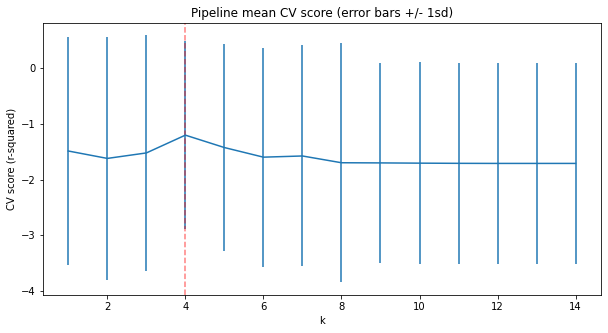

In [29]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10,5))
plt.errorbar(cv_k,score_mean,yerr=score_std)
plt.axvline(x=best_k,c='r',ls='--',alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

### ????

I have time series data of energy consumption for 1449 buildings for one year. The target variable is the energy consumption baseline (so energy consumption for each hour of the year) and the features are the building characteristics and the weather conditions. I am in the stage of trying out different machine learning algorithms, and trying to figure out how to do the train/test splitting. I will state it more explicitly here:

My dataset looks like the following. I have building_id, and for each building_id I have a timestamp at a particular hour with the energy meter reading. At each timestamp I also have the weather conditions such as cloud coverage, precipitation, and air temperature. For this weather data, I have a site_id. A site_id can have multiple building_ids. 

I don't think I can use the train_test_split function because this shuffles all of the data and I need to keep my timeseries data for each building together. 

Because I only have 1 year worth of data, I don't think it would be appropriate to split across the time series. For example, I don't think it would make sense to use as training Jan-Sept to predict Oct-Dec. What I believe I need to do is split across the building_ids. But I don't know how to code for this. 

One thing I attempted was to use the building information data set to create the training and testing sets based on the buildings, then use that information to split the bigger dataset that contains the time series. The are two issues with this: I no longer have information about the variability in the weather and also the energy consumption. And I imagine this information is important for properly splitting the data. 

All of this also becomes an issue in the cross validation I think. I have looked into the TimeSeriesSplit, but I honestly don't really understand how it works.  


The other issue that I am running into is that this is a lot of data, and there isn't enough memory on my computer to process all of the data. I have tried just taking a sample from training data, 100,000 rows, and for example, if I try the method above of doing the training/test split on the building_ids, I end up with about ~10 buildings out of the 1449 that I can potential process on my computer! (100,000 hour meter readings/8760 hours in 1 year). Seems like very little for training. 
